# GDA

Giải bài toán Example 2 bằng thuật toán GDA

Điểm khởi tạo 1: [-0.5, 0.5, -0.5, 0.1]
Điểm sau điều chỉnh: [-0.5, 0.5, -2.0, 0.1]
Hàm mục tiêu hội tụ sau 79 vòng lặp
Nghiệm tối ưu: x* = [-1.06918417e+00  4.18304835e-01 -5.34850992e-01  6.98004822e-10]
Giá trị tối ưu: f* = -3.090770
Số vòng lặp: 80
g1(x*) = 7.427071
g2(x*) = 0.661631
eq(x*) = 0.000000
✓ Nghiệm thỏa mãn các ràng buộc

Điểm khởi tạo 2: [-1.0, 0.3, -0.2, 0.05]
Điểm sau điều chỉnh: [-1.0, 0.3, -0.19999999999999996, 0.05]
Hàm mục tiêu hội tụ sau 58 vòng lặp
Nghiệm tối ưu: x* = [-1.06936610e+00  4.18289467e-01 -5.34425676e-01  1.38042818e-08]
Giá trị tối ưu: f* = -3.090770
Số vòng lặp: 59
g1(x*) = 7.427852
g2(x*) = 0.661613
eq(x*) = 0.000000
✓ Nghiệm thỏa mãn các ràng buộc

Điểm khởi tạo 3: [-0.8, 0.4, -0.6, 0.08]
Điểm sau điều chỉnh: [-0.8, 0.4, -1.0, 0.08]
Hàm mục tiêu hội tụ sau 64 vòng lặp
Nghiệm tối ưu: x* = [-1.06917028e+00  4.18301219e-01 -5.34864312e-01  6.07696950e-09]
Giá trị tối ưu: f* = -3.090770
Số vòng lặp: 65
g1

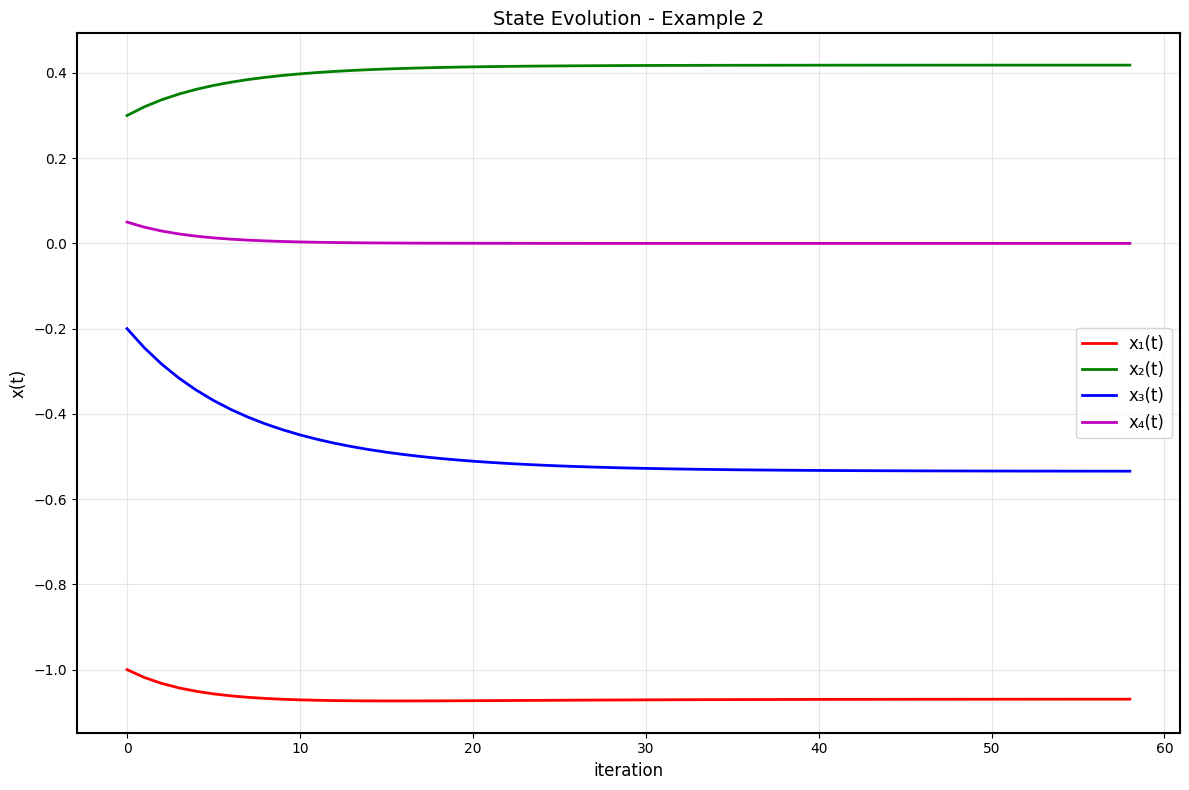

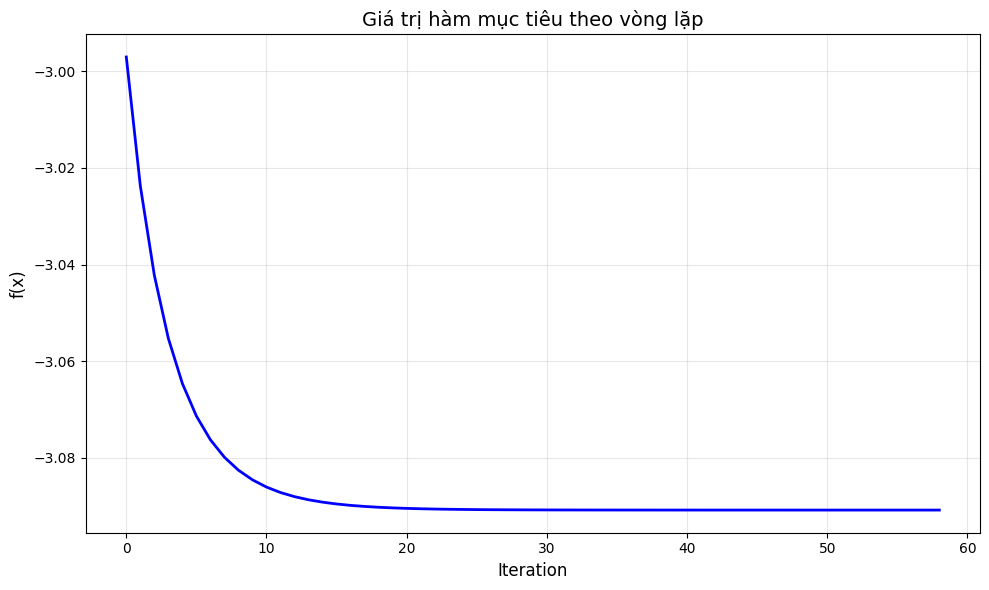

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

class GDA_Solver_Example2:
    def __init__(self, sigma=0.4, kappa=0.7, max_iter=100, tol=1e-8):
        # """
        # Thuật toán GDA cho Example 2
        # """
        self.sigma = sigma
        self.kappa = kappa
        self.max_iter = max_iter
        self.tol = tol
    
    def objective_function(self, x):
        # """
        # Hàm mục tiêu: f(x) = (e^|x_2-3| - 30) / (x_1^2 + x_3^2 + 2x_4^2 + 4)
        # """
        numerator = np.exp(abs(x[1] - 3)) - 30
        denominator = x[0]**2 + x[2]**2 + 2*x[3]**2 + 4
        return numerator / denominator
    
    def gradient_objective(self, x):
        # """
        # Gradient của hàm mục tiêu
        # """
        numerator = np.exp(abs(x[1] - 3)) - 30
        denominator = x[0]**2 + x[2]**2 + 2*x[3]**2 + 4
        f_x = numerator / denominator
        
        # Đạo hàm riêng theo x_1
        df_dx1 = -2 * x[0] * f_x / denominator
        
        # Đạo hàm riêng theo x_2 (xử lý hàm |x_2 - 3|)
        if x[1] > 3:
            df_dx2 = np.exp(x[1] - 3) / denominator
        elif x[1] < 3:
            df_dx2 = -np.exp(3 - x[1]) / denominator
        else:  # x[1] == 3, sử dụng subgradient
            df_dx2 = 0  # Chọn một subgradient
        
        # Đạo hàm riêng theo x_3
        df_dx3 = -2 * x[2] * f_x / denominator
        
        # Đạo hàm riêng theo x_4
        df_dx4 = -4 * x[3] * f_x / denominator
        
        return np.array([df_dx1, df_dx2, df_dx3, df_dx4])
    
    def constraint_g1(self, x):
        # """
        # g1(x) = (x_1 + x_3)^2 + 2x_4^2 <= 10
        # """
        return 10 - ((x[0] + x[2])**2 + 2*x[3]**2)
    
    def constraint_g2(self, x):
        # """
        # g2(x) = (x_2 - 1)^2 <= 1
        # """
        return 1 - (x[1] - 1)**2
    
    def constraint_eq(self, x):
        # """
        # 2x_1 + 4x_2 + x_3 = -1
        # """
        return 2*x[0] + 4*x[1] + x[2] + 1
    
    def is_feasible(self, x, tol=1e-6):
        # """
        # Kiểm tra tính khả thi
        # """
        return (self.constraint_g1(x) >= -tol and 
                self.constraint_g2(x) >= -tol and 
                abs(self.constraint_eq(x)) <= tol)
    
    def project_to_feasible(self, point):
        # """
        # Chiếu điểm về miền khả thi
        # """
        def distance_squared(y):
            return np.sum((y - point)**2)
        
        # Ràng buộc
        cons = [
            {'type': 'ineq', 'fun': self.constraint_g1},
            {'type': 'ineq', 'fun': self.constraint_g2},
            {'type': 'eq', 'fun': self.constraint_eq}
        ]
        
        # Giải bài toán chiếu
        result = minimize(distance_squared, point, constraints=cons, 
                         method='SLSQP', options={'ftol': 1e-12})
        
        if result.success:
            return result.x
        else:
            # Nếu không thành công, thử với điểm khởi tạo khác
            for _ in range(3):
                new_start = point + np.random.normal(0, 0.1, size=point.shape)
                result = minimize(distance_squared, new_start, constraints=cons, 
                                method='SLSQP', options={'ftol': 1e-12})
                if result.success:
                    return result.x
            return point
    
    def solve(self, x0, lambda0=0.1):
        # """
        # Thuật toán GDA
        # """
        x = np.array(x0, dtype=float)
        lambda_k = lambda0
        
        # Đảm bảo điểm khởi tạo khả thi
        if not self.is_feasible(x):
            x = self.project_to_feasible(x)
        
        history = {
            'x': [x.copy()],
            'f': [self.objective_function(x)],
            'lambda': [lambda_k]
        }
        
        for k in range(self.max_iter):
            # Tính gradient
            grad_k = self.gradient_objective(x)
            
            # Tính x^{k+1} candidate
            x_new = x - lambda_k * grad_k
            x_new = self.project_to_feasible(x_new)
            
            # Tính giá trị hàm mục tiêu
            f_k = self.objective_function(x)
            f_new = self.objective_function(x_new)
            
            # Kiểm tra điều kiện Armijo (GDA)
            inner_product = np.dot(grad_k, x - x_new)
            armijo_condition = f_new <= f_k - self.sigma * inner_product
            
            if armijo_condition:
                # Chấp nhận bước và giữ stepsize
                x = x_new
            else:
                # Giảm stepsize và thử lại
                lambda_k *= self.kappa
                x_new = x - lambda_k * grad_k
                x_new = self.project_to_feasible(x_new)
                x = x_new
            
            # Lưu lịch sử
            history['x'].append(x.copy())
            history['f'].append(self.objective_function(x))
            history['lambda'].append(lambda_k)
            
            # Kiểm tra điều kiện dừng
            if k > 0:
                if np.linalg.norm(x - history['x'][-2]) < self.tol:
                    print(f"Hội tụ sau {k+1} vòng lặp")
                    break
                if abs(history['f'][-1] - history['f'][-2]) < self.tol:
                    print(f"Hàm mục tiêu hội tụ sau {k+1} vòng lặp")
                    break
        
        return x, self.objective_function(x), history

def plot_state_evolution(history, title="State Evolution - Example 2"):
    # """
    # Vẽ đồ thị tiến hóa trạng thái x1, x2, x3, x4
    # """
    x_path = np.array(history['x'])
    iterations = range(len(x_path))
    
    plt.figure(figsize=(12, 8))
    
    # Vẽ từng thành phần
    plt.plot(iterations, x_path[:, 0], 'r-', linewidth=2, label='x₁(t)')
    plt.plot(iterations, x_path[:, 1], 'g-', linewidth=2, label='x₂(t)')
    plt.plot(iterations, x_path[:, 2], 'b-', linewidth=2, label='x₃(t)')
    plt.plot(iterations, x_path[:, 3], 'm-', linewidth=2, label='x₄(t)')
    
    # Định dạng đồ thị
    plt.xlabel('iteration', fontsize=12)
    plt.ylabel('x(t)', fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    
    # Thêm khung viền
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
    
    plt.tight_layout()
    plt.show()

def plot_objective_evolution(history):
    # """
    # Vẽ đồ thị giá trị hàm mục tiêu
    # """
    iterations = range(len(history['f']))
    
    plt.figure(figsize=(10, 6))
    plt.plot(iterations, history['f'], 'b-', linewidth=2)
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('f(x)', fontsize=12)
    plt.title('Giá trị hàm mục tiêu theo vòng lặp', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Chạy thử nghiệm
if __name__ == "__main__":
    # Khởi tạo solver
    solver = GDA_Solver_Example2(sigma=0.4, kappa=0.7, max_iter=100, tol=1e-8)
    
    # Các điểm khởi tạo khác nhau
    initial_points = [
        [-0.5, 0.5, -0.5, 0.1],
        [-1.0, 0.3, -0.2, 0.05],
        [-0.8, 0.4, -0.6, 0.08],
        [-1.2, 0.2, -0.3, 0.02],
        [-0.6, 0.6, -0.4, 0.12]
    ]
    
    print("Giải bài toán Example 2 bằng thuật toán GDA")
    print("="*50)
    
    results = []
    history_list = []
    
    for i, x0 in enumerate(initial_points):
        print(f"\nĐiểm khởi tạo {i+1}: {x0}")
        
        # Điều chỉnh x3 để thỏa mãn ràng buộc đẳng thức
        x0[2] = -1 - 2*x0[0] - 4*x0[1]
        print(f"Điểm sau điều chỉnh: {x0}")
        
        try:
            x_opt, f_opt, history = solver.solve(x0)
            results.append((x_opt, f_opt))
            history_list.append(history)
            
            print(f"Nghiệm tối ưu: x* = {x_opt}")
            print(f"Giá trị tối ưu: f* = {f_opt:.6f}")
            print(f"Số vòng lặp: {len(history['f'])}")
            
            # Kiểm tra ràng buộc
            print(f"g1(x*) = {solver.constraint_g1(x_opt):.6f}")
            print(f"g2(x*) = {solver.constraint_g2(x_opt):.6f}")
            print(f"eq(x*) = {solver.constraint_eq(x_opt):.6f}")
            
            if solver.is_feasible(x_opt):
                print("✓ Nghiệm thỏa mãn các ràng buộc")
            else:
                print("✗ Nghiệm vi phạm ràng buộc")
                
        except Exception as e:
            print(f"Lỗi: {e}")
    
    # Thống kê kết quả
    print("\n" + "="*50)
    print("TỔNG KẾT KẾT QUẢ:")
    
    if results:
        f_values = [f for _, f in results]
        best_f = min(f_values)
        avg_f = np.mean(f_values)
        
        print(f"Giá trị tối ưu tốt nhất: {best_f:.6f}")
        print(f"Giá trị trung bình: {avg_f:.6f}")
        print(f"Độ lệch chuẩn: {np.std(f_values):.6f}")
        
        # Tìm nghiệm tốt nhất
        best_idx = np.argmin(f_values)
        best_x = results[best_idx][0]
        print(f"Nghiệm tối ưu tốt nhất: x* = {best_x}")
        
        # Vẽ đồ thị cho nghiệm tốt nhất
        print("\nVẽ đồ thị tiến hóa trạng thái...")
        plot_state_evolution(history_list[best_idx])
        plot_objective_evolution(history_list[best_idx])